In [29]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import reduce
import copy
from datetime import timedelta
import alphalens

/Users/langfordtang/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/Users/langfordtang/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Question 2

## 1.1 Read data

### Trading data
Data source: 英为财情 https://cn.investing.com/

In [2]:
nasdap_df = pd.read_csv("./纳斯达克100指数历史数据.csv")
btc_df = pd.read_csv('./BTC_USD Bitfinex 历史数据.csv')
eth_df = pd.read_csv('./Ethereum - 以太坊历史数据_历史行情,价格,走势图表_英为财情.csv')
xrp_df = pd.read_csv('./XRP - 瑞波币历史数据_历史行情,价格,走势图表_英为财情.csv')

### Key event data
Data source: http://www.btb8.com/rili/list/
             https://coinmarketcal.com/ (备用）

In [3]:
event_data = []
with open("./key_event.txt", 'r', encoding='utf8') as f:
    while(True):
        line = f.readline()
        if not line:
            break
        line = line.split("月")
        month = line[0]
        res = line[1]
        res = res.split('日')
        date = res[0]
        content = res[1].strip(' \u3000\n')
        event_data.append(["2019年"+str(int(month))+"月"+str(int(date))+"日", content])
        
event_df = pd.DataFrame(columns=['日期', '新闻'], data=event_data)

In [4]:
# read traslated news
news_en_data = []
with open("new_en.txt", 'r') as f:
    while(True):
        line = f.readline()
        if not line:
            break
        news_en_data.append(line.strip('\n'))

In [5]:
event_df['新闻_英'] = news_en_data

## 1.2 Data preprocess

In [6]:
# format date
def strdate_format(line):
    strdate = line['日期']
    new_date = datetime.strptime(strdate, '%Y年%m月%d日')
    line['日期'] = new_date.strftime("%Y%m%d")
    return line

nasdap_df = nasdap_df.apply(strdate_format, axis=1)
btc_df = btc_df.apply(strdate_format, axis=1)
eth_df = eth_df.apply(strdate_format, axis=1)
xrp_df = xrp_df.apply(strdate_format, axis=1)
event_df = event_df.apply(strdate_format, axis=1)

In [7]:
# format number
def strnum_format(line):
    if type(line['开盘'])==str:
        price_open = float(line['开盘'].replace(',', ''))
    else:
        price_open = line['开盘']
        
    if type(line['收盘'])==str:
        price_close = float(line['收盘'].replace(',', ''))
    else:
        price_close = line['收盘']
        
    if type(line['高'])==str:
        price_high = float(line['高'].replace(',', ''))
    else:
        price_high = line['高']
    
    if type(line['低']) == str:
        price_low = float(line['低'].replace(',', ''))
    else:
        price_low = line['低']
        
    if 'M' in line['交易量']:
        trade_volumn = float(line['交易量'].replace('M', ''))*10000000
    elif 'K' in line['交易量']:
        trade_volumn = float(line['交易量'].replace('K', ''))*1000
    elif 'B' in line['交易量']:
        trade_volumn = float(line['交易量'].replace('B', ''))*1000000000
    else:
        trade_volumn = float(line['交易量'])
        
    percent = float(line['涨跌幅'].replace('%',''))*0.01
        
    
    line['开盘'] = price_open
    line['收盘'] = price_close
    line['高'] = price_high
    line['低'] = price_low
    line['交易量'] = trade_volumn
    line['涨跌幅'] = percent
    
    return line

In [8]:
nasdap_df = nasdap_df.apply(strnum_format, axis=1)

btc_df = btc_df.apply(strnum_format, axis=1)

eth_df = eth_df.apply(strnum_format, axis=1)

xrp_df = xrp_df.apply(strnum_format, axis=1)

## 1.2 Key event

### plot time line

In [9]:
# plot
dates = [datetime.strptime(date, "%Y%m%d") for date in event_df['日期']]
names = [event for event in event_df['新闻_英']]

/Users/langfordtang/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: stem() got an unexpected keyword argument 'use_line_collection'. This will raise a TypeError in future versions.
  warnings.warn(message, mplDeprecation, stacklevel=1)


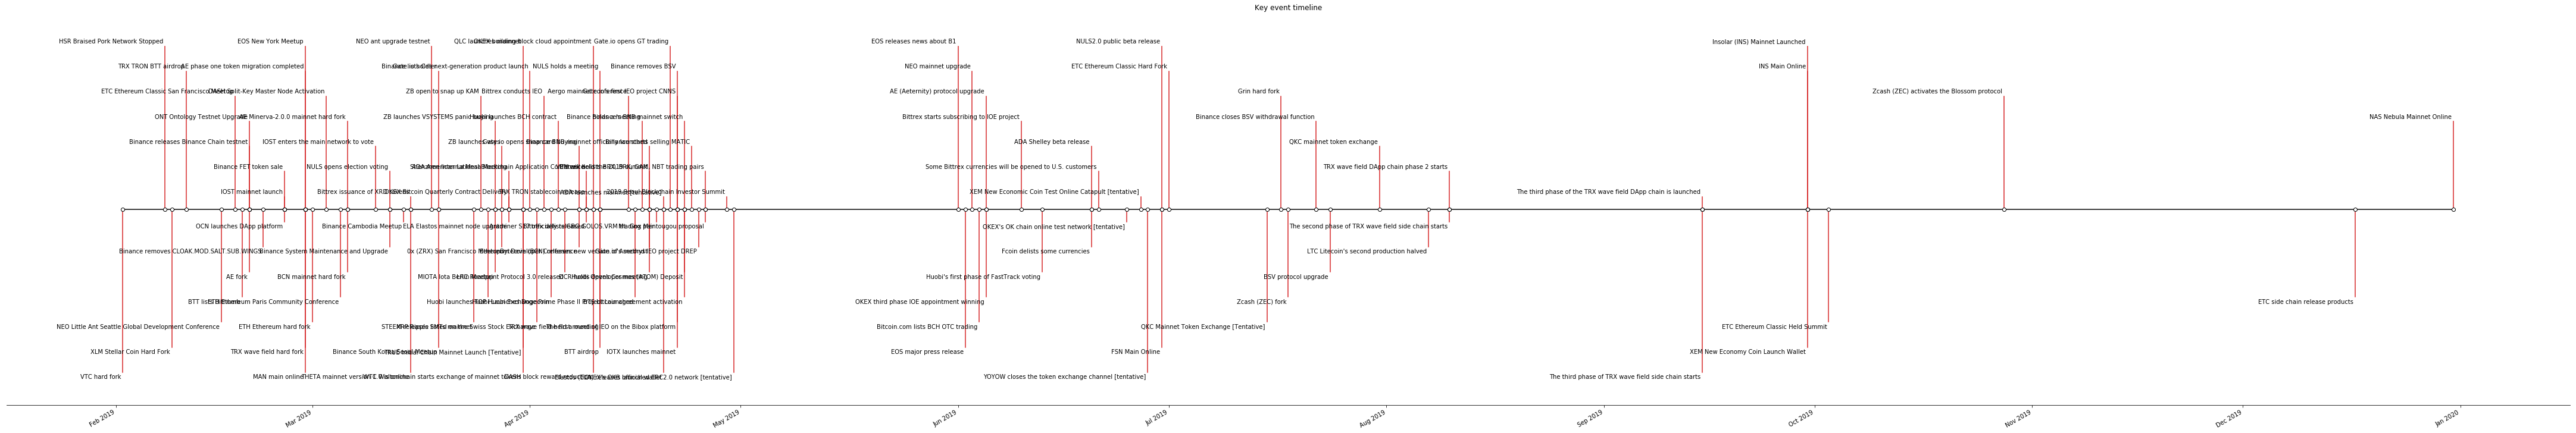

In [10]:
# Choose some nice levels
levels = np.tile([-13,13,-11,11, -9,9,-7, 7, -5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(60,10), constrained_layout=True)
ax.set(title="Key event timeline")

markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)

plt.setp(markerline, mec="k", mfc="w", zorder=3)

# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(dates)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(dates, levels, names, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

# format xaxis with 4 month intervals
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.1)
plt.show()

## 1.3  BTC on key event day

In [11]:
# merge btc data and event
event_btc_df = nasdap_df.merge(event_df, on='日期', how='left')
# sort by date
event_btc_df.sort_values('日期', inplace=True)
event_btc_df.reset_index(inplace=True, drop=True)

In [12]:
event_day_return = event_btc_df[~event_btc_df['新闻'].isna()]['涨跌幅']

### Staticstic of BTC return

In [13]:
print("Statistic of BTC return on key day.")
print()
print(event_day_return.describe())

Statistic of BTC return on key day.

count    97.000000
mean      0.002654
std       0.006497
min      -0.021000
25%      -0.000600
50%       0.002800
75%       0.007000
max       0.027000
Name: 涨跌幅, dtype: float64


### Distribution of return

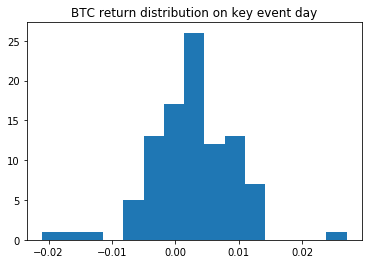

In [14]:
plt.hist(event_day_return, bins=15)
plt.title("BTC return distribution on key event day")
plt.show()

### Correlation matrix

In [15]:
nasdap_return_df = nasdap_df[['日期', '涨跌幅']].rename(columns={'日期':'date', '涨跌幅':'nasdap_return'})
btc_return_df = btc_df[['日期', '涨跌幅']].rename(columns={'日期':'date', '涨跌幅':'btc_return'})
eth_return_df = eth_df[['日期', '涨跌幅']].rename(columns={'日期':'date', '涨跌幅':'eth_return'})
xrp_return_df = xrp_df[['日期', '涨跌幅']].rename(columns={'日期':'date', '涨跌幅':'xrp_return'})

In [16]:
event_new_df = event_df.rename(columns={'日期':'date', '新闻':'event', '新闻_英':'event_en'})

all_return_df = nasdap_return_df.merge(btc_return_df, how='left', on='date').merge(eth_return_df, how='left', on='date').merge(xrp_return_df, how='left', on='date')

all_return_event_df = all_return_df.merge(event_new_df, how='left', on='date')

In [17]:
eventday_data = all_return_event_df[~all_return_event_df['event'].isna()]
noeventday_data = all_return_event_df[all_return_event_df['event'].isna()]

In [18]:
# sort on date
eventday_data = eventday_data.sort_values('date').reset_index(drop=True)
noeventday_data = noeventday_data.sort_values('date').reset_index(drop=True)

In [19]:
# matrix
return_names = ['nasdap_return','btc_return','eth_return','xrp_return']
print("Correlation Matrix on event day.")
print(eventday_data[return_names].corr())
print()

print("Correlation Matrix on no event day.")
return_names = ['nasdap_return','btc_return','eth_return','xrp_return']
print(noeventday_data[return_names].corr())
print()

Correlation Matrix on event day.
               nasdap_return  btc_return  eth_return  xrp_return
nasdap_return       1.000000    0.019491    0.054738    0.093050
btc_return          0.019491    1.000000    0.852720    0.729839
eth_return          0.054738    0.852720    1.000000    0.844543
xrp_return          0.093050    0.729839    0.844543    1.000000

Correlation Matrix on no event day.
               nasdap_return  btc_return  eth_return  xrp_return
nasdap_return       1.000000   -0.049877    0.041651    0.075101
btc_return         -0.049877    1.000000    0.802492    0.606271
eth_return          0.041651    0.802492    1.000000    0.760784
xrp_return          0.075101    0.606271    0.760784    1.000000



### multivariate regression analysis

In [20]:
# create binary variable
regression_df = copy.deepcopy(all_return_event_df)
regression_df['event_variable']=0
regression_df.loc[~regression_df['event'].isna(), 'event_variable'] = 1
regression_df.drop(['event', 'event_en'], axis=1, inplace=True)

In [21]:
# Regression other variable on btc return
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(regression_df[['nasdap_return','eth_return','xrp_return','event_variable']], regression_df['btc_return'])

print("Regression other variable on btc return:")
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print('Variables: \n', ['nasdap_return','eth_return','xrp_return','event_variable'])

Regression other variable on btc return:
Intercept: 
 0.0020278373048494775
Coefficients: 
 [-0.26993589  0.72168732  0.00793805  0.00154816]
Variables: 
 ['nasdap_return', 'eth_return', 'xrp_return', 'event_variable']


In [22]:
# Regression binary event variable on btc return
regr = linear_model.LinearRegression()
regr.fit(regression_df[['event_variable']], regression_df['btc_return'])

print("Regression other variable on btc return:")
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print('Variables: \n', ['event_variable'])

Regression other variable on btc return:
Intercept: 
 0.001206842105263158
Coefficients: 
 [0.00966945]
Variables: 
 ['event_variable']


# Question 3

In [23]:
btc_df2 = pd.read_csv('./Bitcoin - 比特币历史数据_历史行情,价格,走势图表_英为财情18-20.csv')
eth_df2 = pd.read_csv('./Ethereum - 以太坊历史数据_历史行情,价格,走势图表_英为财情18-20.csv')
xrp_df2 = pd.read_csv('./XRP - 瑞波币历史数据_历史行情,价格,走势图表_英为财情18-20.csv')
ltc_df2 = pd.read_csv('./Litecoin - 莱特币历史数据_历史行情,价格,走势图表_英为财情18-20.csv')

In [24]:
# 标准化
btc_df2 = btc_df2.apply(strdate_format, axis=1)
eth_df2 = eth_df2.apply(strdate_format, axis=1)
xrp_df2 = xrp_df2.apply(strdate_format, axis=1)
ltc_df2 = ltc_df2.apply(strdate_format, axis=1)

btc_df2 = btc_df2.apply(strnum_format, axis=1)
eth_df2 = eth_df2.apply(strnum_format, axis=1)
xrp_df2 = xrp_df2.apply(strnum_format, axis=1)
ltc_df2 = ltc_df2.apply(strnum_format, axis=1)

btc_df2 = btc_df2.rename(columns={"收盘":"btc_收盘", "涨跌幅":"btc_涨跌幅"}).drop(['开盘','高','低','交易量'], axis=1)
eth_df2 = eth_df2.rename(columns={"收盘":"eth_收盘", "涨跌幅":"eth_涨跌幅"}).drop(['开盘','高','低','交易量'], axis=1)
xrp_df2 = xrp_df2.rename(columns={"收盘":"xrp_收盘", "涨跌幅":"xrp_涨跌幅"}).drop(['开盘','高','低','交易量'], axis=1)
ltc_df2 = ltc_df2.rename(columns={"收盘":"ltc_收盘", "涨跌幅":"ltc_涨跌幅"}).drop(['开盘','高','低','交易量'], axis=1)

In [25]:
price_df = reduce(lambda df1,df2: pd.merge(df1,df2,on='日期'), [btc_df2, eth_df2, xrp_df2, ltc_df2])

In [26]:
def assess_portfolio(allocation_dict, start_value, start_date, end_date, price_df):
    """
    @parameters: allocation_dict -- allocation of asset
                                    dictionary format {btc:0.25, eth:0.25, xrp:0.25, ltc:0.25}
                 start_value -- start value of the portfolio
                 start_date -- start date of backtest, ie. 20180508
                 end_date -- end date of backtest
                 price_df -- daily price of uderlying asset
    """
    # convert datetime
    price_df = price_df.sort_values('日期').reset_index(drop=True)
    price_df.日期 = pd.to_datetime(price_df.日期)
    start_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')

    # init asset value
    btc_value = start_value * allocation_dict['btc']
    eth_value = start_value * allocation_dict['eth']
    xrp_value = start_value * allocation_dict['xrp']
    ltc_value = start_value * allocation_dict['ltc']

    daily_portfolio_value = [[start_date, start_value]]
    # iter each day to caculate portfolio value
    for idx, row in price_df.iterrows():
        if row['日期'] < start_date:
            continue
        elif row['日期'] > end_date:
                break
        else:
            btc_value = btc_value*(row['btc_涨跌幅']+1)
            eth_value = eth_value*(row['eth_涨跌幅']+1)
            xrp_value = xrp_value*(row['xrp_涨跌幅']+1)
            ltc_value = ltc_value*(row['ltc_涨跌幅']+1)

            portfolio_daily_value = btc_value+eth_value+xrp_value+ltc_value

            daily_portfolio_value.append([row['日期'], portfolio_daily_value, btc_value, eth_value, xrp_value, ltc_value])

    portfolio_value_df = pd.DataFrame(daily_portfolio_value, columns=['日期', '组合净值', 'btc', 'eth', 'xrp', 'ltc'])
    # daily return
    portfolio_value_df['涨跌幅'] = portfolio_value_df['组合净值']/portfolio_value_df['组合净值'].shift(1)-1

    # plot portfolio value
    import matplotlib.dates as mdates
    plt.figure(figsize=(15,5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    x = portfolio_value_df['日期']
    plt.plot(x,portfolio_value_df['组合净值'])
    plt.plot(x, portfolio_value_df['btc'])
    plt.plot(x, portfolio_value_df['eth'])
    plt.plot(x, portfolio_value_df['xrp'])
    plt.plot(x, portfolio_value_df['ltc'])
    plt.legend(['portfolio value', 'btc', 'eth', 'xrp', 'ltc'])
    plt.title('portfolio value')
    plt.gcf().autofmt_xdate()
    plt.show()

    # plot moving historical volatility
    import matplotlib.dates as mdates
    plt.figure(figsize=(15,5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    x = portfolio_value_df['日期']
    plt.plot(x,portfolio_value_df['涨跌幅'].rolling(30).std())
    plt.title('moving historical volatility')
    plt.gcf().autofmt_xdate()
    plt.show()

    # start and end value
    print("portfolio start value: {}".format(start_value))
    print("portfolio end value: {}".format(portfolio_value_df['组合净值'].iloc[-1].round(3)))

    # cumulative return
    cumulative_return = (portfolio_value_df['组合净值'].iloc[-1]/portfolio_value_df['组合净值'].iloc[0]-1)
    print("Portfolio cumulative_return: {}%".format(cumulative_return.round(6)*100))

    print("Portfolio daily return mean: {}%".format((portfolio_value_df['涨跌幅'].describe()['mean']*100).round(3)))
    print("Portfolio daily return std: {}".format(portfolio_value_df['涨跌幅'].describe()['std'].round(3)))

    # sharpe ratio
    SR=portfolio_value_df['涨跌幅'].mean()/portfolio_value_df['涨跌幅'].std()
    ASR=np.sqrt(252)*SR

    print("Portfolio annulised sharp ratio: ", ASR.round(3))

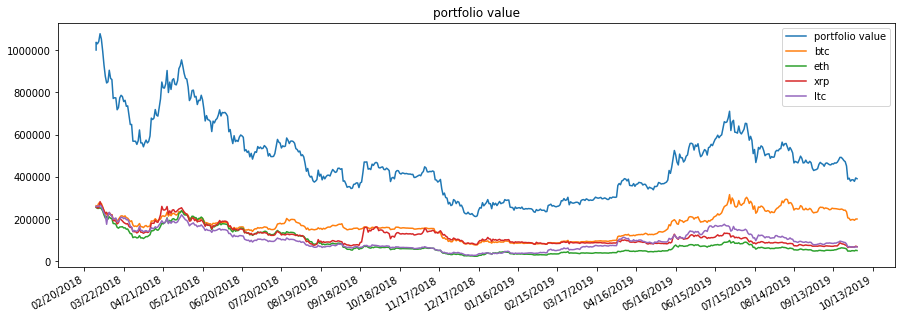

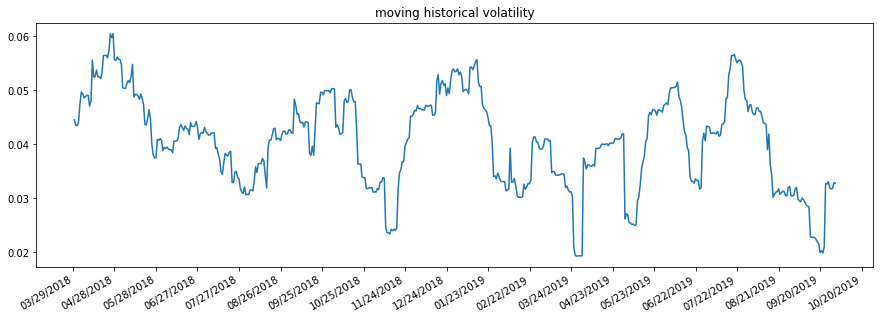

portfolio start value: 1000000
portfolio end value: 391229.574
Portfolio cumulative_return: -60.877%
Portfolio daily return mean: -0.075%
Portfolio daily return std: 0.042
Portfolio annulised sharp ratio:  -0.287


In [27]:
start_date = '20180301'
end_date = '20191001'
allocation_dict = {'btc':0.25, 'eth':0.25, 'xrp':0.25, 'ltc':0.25}
start_value = 1000000

assess_portfolio(allocation_dict, start_value, start_date, end_date, price_df)

# Question 4

In [334]:
# make event_indicator
event_df = btc_df2.merge(eth_df2, how='left', on='日期')
event_df['event_indicator'] = 0
# 选取了btc和eth同时下跌超过5%作为event
# assignment中同时下跌10%的event发生的频率太小，两年只有十几次，样本量不够
event_df.loc[(event_df['btc_涨跌幅']<-0.05) & (event_df['eth_涨跌幅']<-0.05), ['event_indicator']] = 1

## alphalens analysis

In [335]:
# price_df reshape for alphalens
tmp = copy.deepcopy(event_df[['日期', 'btc_收盘']])
tmp['ts_code']='btc'
tmp.rename(columns={'日期':'trade_date', 'btc_收盘':'close'}, inplace=True)
tmp.trade_date = pd.to_datetime(tmp.trade_date)

tmp2 = copy.deepcopy(event_df[['日期', 'eth_收盘']])
tmp2['ts_code']='eth'
tmp2.rename(columns={'日期':'trade_date', 'eth_收盘':'close'}, inplace=True)
tmp2.trade_date = pd.to_datetime(tmp2.trade_date)

event_price_df = pd.concat([tmp, tmp2])

In [336]:
# factor_df reshape for alphalens
tmp = copy.deepcopy(event_df[['日期', 'event_indicator']])
tmp['ts_code']='btc'
tmp.rename(columns={'日期':'trade_date', 'btc_收盘':'close'}, inplace=True)
tmp.trade_date = pd.to_datetime(tmp.trade_date)

tmp2 = copy.deepcopy(event_df[['日期', 'event_indicator']])
tmp2['ts_code']='eth'
tmp2.rename(columns={'日期':'trade_date', 'eth_收盘':'close'}, inplace=True)
tmp2.trade_date = pd.to_datetime(tmp2.trade_date)

event_factor_df = pd.concat([tmp, tmp2])

In [337]:
# 提取因子
factor = event_factor_df.loc[:,['ts_code','trade_date', 'event_indicator']].set_index(['trade_date','ts_code'])
factor = factor.unstack().fillna(method='ffill').stack()
# 提取收盘价：使用前复权价格，reshape 满足alphalens接口要求
prices = event_price_df.pivot(index='trade_date',columns='ts_code',values='close')
# 计算股票到期收益率，并与因子对应
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(
    factor,
    prices,
    groupby=None,
    quantiles=1,
    periods=[1,2,3,4,5,7,9,10,13],
    max_loss=0.4,
    filter_zscore=None)

Dropped 1.8% entries from factor data: 1.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!


In [338]:
factor = factor[factor['event_indicator']==1]
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(
    factor,
    prices,
    groupby=None,
    quantiles=1,
    periods=[1,2,3,4,5,7,9,10,13],
    max_loss=0.4,
    filter_zscore=None)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1,1,1,0.0,90,100.0


<Figure size 432x288 with 0 Axes>

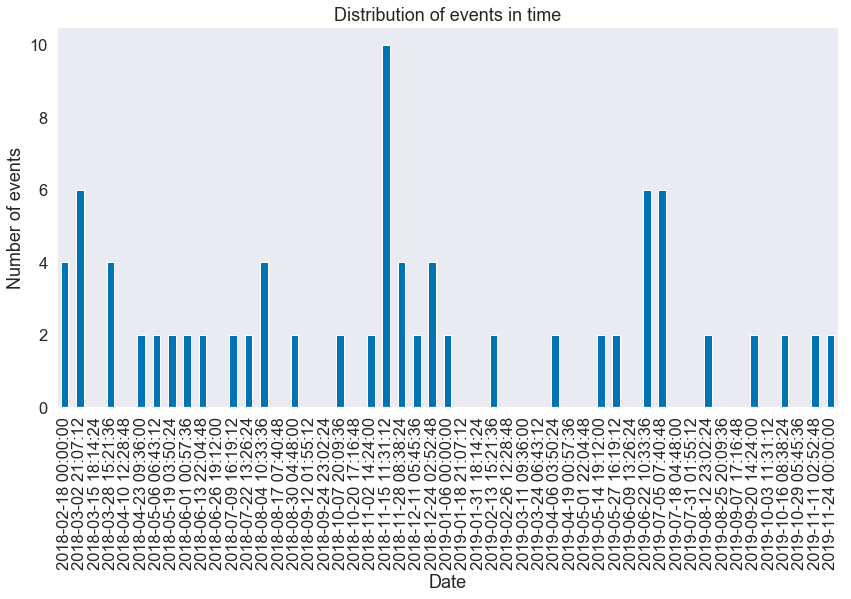

/Users/langfordtang/anaconda3/lib/python3.7/site-packages/alphalens/tears.py:728: UserWarning: 'freq' not set in factor_data index: assuming business day
  UserWarning,


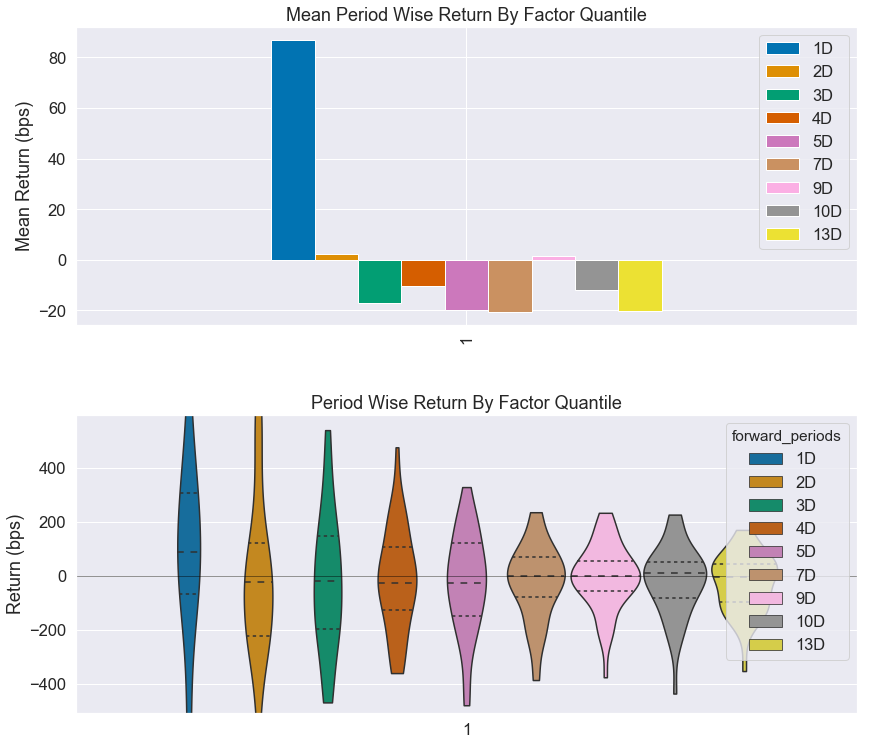

In [339]:
alphalens.tears.create_event_study_tear_sheet(factor_data, returns=None)

## Myself event analysis

In [340]:
periods = [-5,-4,-3,-2,-1,0,1,2,3,4,5,6,8,10,12]

In [341]:
# get forward return
for i in periods:
    # forward close
    event_df['btc_收盘_{}_day_after'.format(str(i).zfill(3))] = event_df['btc_收盘'].shift(-i)
    # forward cumulative return
    event_df['btc_cr_{}_day_after'.format(str(i).zfill(3))] = ((event_df['btc_收盘'].shift(-i)) / (event_df['btc_收盘'])) -1

In [342]:
# get forward return mean and std
cr_stat_df = pd.DataFrame()
for i in periods:
    period_str = str(i).zfill(3)
    # all date
    all_date_cr_mean = event_df['btc_cr_{}_day_after'.format(period_str)].mean()
    all_date_cr_std = event_df['btc_cr_{}_day_after'.format(period_str)].std()

    # key event date
    key_event_df = event_df[event_df['event_indicator']==1]
    key_event_cr_mean = key_event_df['btc_cr_{}_day_after'.format(period_str)].mean()
    key_event_cr_std = key_event_df['btc_cr_{}_day_after'.format(period_str)].std()

    # nonkey event date
    nonkey_event_df = event_df[event_df['event_indicator']==0]
    nonkey_event_cr_mean = nonkey_event_df['btc_cr_{}_day_after'.format(period_str)].mean()
    nonkey_event_cr_std = nonkey_event_df['btc_cr_{}_day_after'.format(period_str)].std()

    iperiod_df = pd.DataFrame({'forward_day':[i],
                               'all_date_cr_mean':[all_date_cr_mean],
                               'all_date_cr_std':[all_date_cr_std],
                               'key_event_cr_mean':[key_event_cr_mean],
                               'key_event_cr_std':[key_event_cr_std],
                               'nonkey_event_cr_mean':[nonkey_event_cr_mean],
                               'nonkey_event_cr_std':[nonkey_event_cr_std]})
    cr_stat_df = cr_stat_df.append(iperiod_df)
    
#     # print
#     print("== {} day forward ==".format(period_str))
#     print("all data cumulative return mean: {:.3f}%".format(100*all_date_cr_mean))
#     print("all data cumulative return std: {:.3f}".format(all_date_cr_std))
#     print()
#     print("key event cumulative return mean: {:.3f}%".format(100*key_event_cr_mean))
#     print("key event cumulative return std: {:.3f}".format(key_event_cr_std))
#     print()
#     print("nonkey event cumulative return mean: {:.3f}%".format(100*nonkey_event_cr_mean))
#     print("nonkey event cumulative return std: {:.3f}".format(nonkey_event_cr_std))
#     print()
    
cr_stat_df = cr_stat_df.set_index('forward_day')

In [343]:
cr_stat_df

,all_date_cr_mean,all_date_cr_std,key_event_cr_mean,key_event_cr_std,nonkey_event_cr_mean,nonkey_event_cr_std
forward_day,,,,,,
-5,0.003090,0.081936,-0.003466,0.084346,0.003524,0.081820
-4,0.002509,0.072696,-0.000575,0.073971,0.002712,0.072662
-3,0.001801,0.061989,-0.001751,0.069650,0.002035,0.061500
-2,0.001241,0.049942,-0.000052,0.053989,0.001326,0.049705
-1,0.000637,0.036253,0.006090,0.036514,0.000279,0.036234
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000674,0.036342,0.085450,0.028308,-0.004895,0.029193
2,0.001235,0.049939,0.083937,0.056417,-0.004205,0.044418
3,0.002013,0.062068,0.092145,0.068417,-0.003925,0.056862


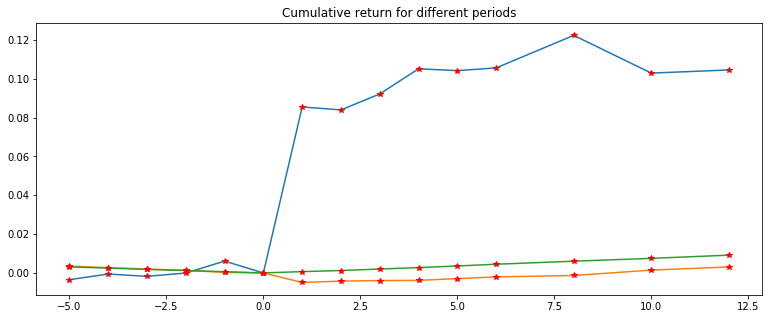

In [344]:
# key event cumulative return 画图
plt.figure(figsize=(13,5))
x = cr_stat_df.index.to_numpy()

plt.plot(x,cr_stat_df['key_event_cr_mean'])
plt.plot(x,cr_stat_df['nonkey_event_cr_mean'])
plt.plot(x,cr_stat_df['all_date_cr_mean'])

plt.plot(x,cr_stat_df['key_event_cr_mean'],'r*')
plt.plot(x,cr_stat_df['nonkey_event_cr_mean'],'r*')
plt.plot(x,cr_stat_df['all_date_cr_mean'],'r*')

# plt.legend(['key_event_cr_mean','nonkey_event_cr_mean','all_date_cr_mean'])
plt.title('Cumulative return for different periods')
plt.show()

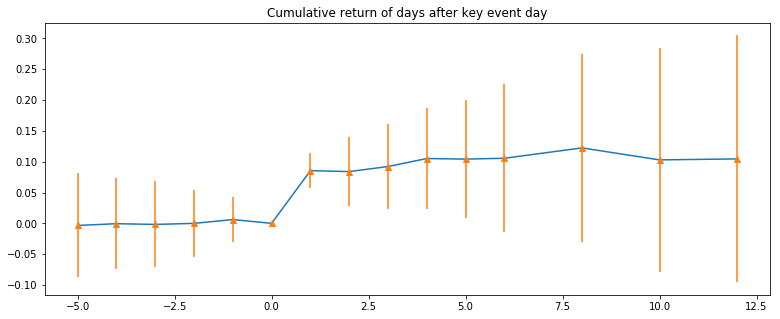

In [345]:
# key event day with error bar
plt.figure(figsize=(13,5))
plt.title('Cumulative return of days after key event day')
plt.plot(x, cr_stat_df['key_event_cr_mean'])
plt.errorbar(x, cr_stat_df['key_event_cr_mean'], cr_stat_df['key_event_cr_std'], linestyle='None', marker='^')
plt.show()

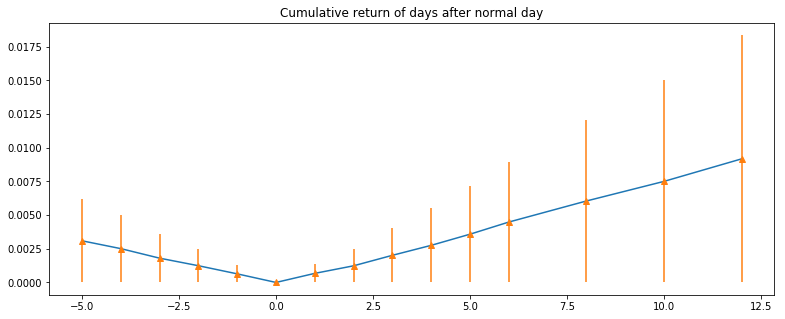

In [346]:
# all day with error bar
plt.figure(figsize=(13,5))
plt.title('Cumulative return of days after normal day')
plt.plot(x, cr_stat_df['all_date_cr_mean'])
plt.errorbar(x, cr_stat_df['all_date_cr_mean'], cr_stat_df['all_date_cr_mean'], linestyle='None', marker='^')
plt.show()

## Analysis of the graph and strategy:

A strategy can be applied for buying BTC on the key event day, hold for 5 days, and then sell.

# Question 5

In [424]:
class back_test():
    price_df = None
    init_value = None
    
    """ 
    Name: hold_position
    Type: Dict of dict
    Example: {trade_id: {stock_name:btc,
                         buy_value:1000,
                         sell_value: 1200,
                         buy_date: 2020-02-02,
                         sell_date: 2020-02-03,
                         is_close: True}
              }
    """
    # 股票持仓
    hold_position = None
    
    # 现金市值
    cash_value = None
    
    # 组合市值
    portfolio_value = None
    portfolio_value_history = None
    
    def __init__(self, price_df, init_value):
        """类初始化"""
        # history data
        self.price_df = price_df
        # iter over whole history
        self.day_iter = 0
        # 初始资金
        self.init_value = init_value
        self.portfolio_value_history = []
        self.cash_value = init_value
        self.hold_position = {}
        
    def strategy(self,current_info_df):
        """
        @describe: 休市后的调仓策略
        @parameter: current_info_df -- 当前可见的历史信息
        """
        
        btc_return_today = ((current_info_df.iloc[-1]['btc_收盘']) / (current_info_df.iloc[-2]['btc_收盘'])) -1
        eth_return_today = ((current_info_df.iloc[-1]['eth_收盘']) / (current_info_df.iloc[-2]['eth_收盘'])) -1
        
        #==============================================================#
        # buy options
        if btc_return_today<-0.05 and eth_return_today<-0.05:
            # key event day
            trade_id = len(self.hold_position)+1
            stock_name = 'btc'
            buy_value = current_info_df.iloc[-1]['btc_收盘']
            sell_value = None
            buy_date = current_info_df.iloc[-1]['日期']
            sell_date = None
            is_close = False
            
            # 检查现金是否够买btc
            if buy_value > self.cash_value:
                return 'event day but lack of cash on {}'.format(buy_date)
            
            # add to hold_position
            self.hold_position[trade_id] = {'stock_name':stock_name,
                                      'buy_value':buy_value,
                                      'sell_value':sell_value,
                                      'buy_date':buy_date,
                                      'sell_date':sell_date,
                                      'is_close':is_close}
            # update cash value
            self.cash_value = self.cash_value - buy_value
            
            print("buy trade {}".format(trade_id))
        #==============================================================#
        
        #==============================================================#
        # sell options: 卖出持仓到一天的
        if len(self.hold_position) != 0:
            for trade_id in self.hold_position:
                # 特定的一笔交易
                itrade_dict = self.hold_position[trade_id]
                if not itrade_dict['is_close']:
                    # 未close的交易
                    current_day = current_info_df.iloc[-1]['日期']
                    buy_day = self.hold_position[trade_id]['buy_date']
                    hold_time = current_day - buy_day
                    if hold_time >= timedelta(15):
                        print("sell trade {} hold time after 10 days".format(trade_id))
                        # 持有天数超过的，卖掉
                        buy_value = self.hold_position[trade_id]['buy_value']
                        sell_value = backtest_df.iloc[-1]['btc_收盘']
                        profit = sell_value - buy_value
                        print("buy value: ", buy_value)
                        print("sell value: ", sell_value)

                        # update hold_position
                        self.hold_position[trade_id]['sell_value'] = sell_value
                        self.hold_position[trade_id]['sell_date'] = current_day
                        self.hold_position[trade_id]['is_close'] = True

                        # update cash value
                        self.cash_value = self.cash_value + sell_value
        #==============================================================#
        
    def update_portfolio_value(self, current_day, current_btc_close):
        """
        @describe: 策略执行完成后更新portfolio value
        """
        portfolio_value = 0
        # iter hold positions
        for trade_id in self.hold_position:
            if not self.hold_position[trade_id]['is_close']:
                portfolio_value = portfolio_value + current_btc_close
                
        # add cash
        portfolio_value = portfolio_value + self.cash_value
        # update
        self.portfolio_value = portfolio_value
        # append to history
        self.portfolio_value_history.append([current_day, portfolio_value])
        
    def iter_each_day(self):
        for idx in self.price_df.index:
            # 当前时间节点能获取到的信息
            if idx==0:
                continue
            current_info_df = self.price_df.iloc[:(idx+1)]
            current_day = current_info_df.iloc[-1]['日期']
            current_btc_close = current_info_df.iloc[-1]['btc_收盘']
            print("iter for day {}".format(current_day))
            # 执行策略
            strategy_info = self.strategy(current_info_df)
            # 更新信息
            self.update_portfolio_value(current_day, current_btc_close)

In [425]:
backtest_df = event_df[['日期','btc_收盘','eth_收盘']].copy()

In [426]:
backtest_df['日期'] = pd.to_datetime(backtest_df['日期']).sort_values().reset_index(drop=True)

In [427]:
myBacktest = back_test(backtest_df, 10000000)

In [428]:
myBacktest.iter_each_day()

iter for day 2018-02-16 00:00:00
iter for day 2018-02-17 00:00:00
iter for day 2018-02-18 00:00:00
iter for day 2018-02-19 00:00:00
iter for day 2018-02-20 00:00:00
iter for day 2018-02-21 00:00:00
iter for day 2018-02-22 00:00:00
iter for day 2018-02-23 00:00:00
iter for day 2018-02-24 00:00:00
iter for day 2018-02-25 00:00:00
iter for day 2018-02-26 00:00:00
iter for day 2018-02-27 00:00:00
iter for day 2018-02-28 00:00:00
iter for day 2018-03-01 00:00:00
iter for day 2018-03-02 00:00:00
iter for day 2018-03-03 00:00:00
iter for day 2018-03-04 00:00:00
iter for day 2018-03-05 00:00:00
iter for day 2018-03-06 00:00:00
iter for day 2018-03-07 00:00:00
iter for day 2018-03-08 00:00:00
iter for day 2018-03-09 00:00:00
iter for day 2018-03-10 00:00:00
iter for day 2018-03-11 00:00:00
iter for day 2018-03-12 00:00:00
iter for day 2018-03-13 00:00:00
iter for day 2018-03-14 00:00:00
iter for day 2018-03-15 00:00:00
iter for day 2018-03-16 00:00:00
iter for day 2018-03-17 00:00:00
iter for d

iter for day 2018-11-13 00:00:00
iter for day 2018-11-14 00:00:00
iter for day 2018-11-15 00:00:00
buy trade 11
iter for day 2018-11-16 00:00:00
iter for day 2018-11-17 00:00:00
iter for day 2018-11-18 00:00:00
iter for day 2018-11-19 00:00:00
iter for day 2018-11-20 00:00:00
iter for day 2018-11-21 00:00:00
iter for day 2018-11-22 00:00:00
iter for day 2018-11-23 00:00:00
buy trade 12
sell trade 10 hold time after 10 days
buy value:  8027.4
sell value:  10037.3
iter for day 2018-11-24 00:00:00
iter for day 2018-11-25 00:00:00
iter for day 2018-11-26 00:00:00
iter for day 2018-11-27 00:00:00
iter for day 2018-11-28 00:00:00
iter for day 2018-11-29 00:00:00
iter for day 2018-11-30 00:00:00
sell trade 11 hold time after 10 days
buy value:  7262.6
sell value:  10037.3
iter for day 2018-12-01 00:00:00
iter for day 2018-12-02 00:00:00
iter for day 2018-12-03 00:00:00
iter for day 2018-12-04 00:00:00
iter for day 2018-12-05 00:00:00
iter for day 2018-12-06 00:00:00
iter for day 2018-12-07 00

iter for day 2019-07-25 00:00:00
iter for day 2019-07-26 00:00:00
iter for day 2019-07-27 00:00:00
iter for day 2019-07-28 00:00:00
iter for day 2019-07-29 00:00:00
iter for day 2019-07-30 00:00:00
iter for day 2019-07-31 00:00:00
iter for day 2019-08-01 00:00:00
iter for day 2019-08-02 00:00:00
iter for day 2019-08-03 00:00:00
iter for day 2019-08-04 00:00:00
iter for day 2019-08-05 00:00:00
iter for day 2019-08-06 00:00:00
iter for day 2019-08-07 00:00:00
iter for day 2019-08-08 00:00:00
iter for day 2019-08-09 00:00:00
iter for day 2019-08-10 00:00:00
iter for day 2019-08-11 00:00:00
iter for day 2019-08-12 00:00:00
iter for day 2019-08-13 00:00:00
iter for day 2019-08-14 00:00:00
iter for day 2019-08-15 00:00:00
iter for day 2019-08-16 00:00:00
iter for day 2019-08-17 00:00:00
iter for day 2019-08-18 00:00:00
iter for day 2019-08-19 00:00:00
iter for day 2019-08-20 00:00:00
iter for day 2019-08-21 00:00:00
iter for day 2019-08-22 00:00:00
iter for day 2019-08-23 00:00:00
iter for d

In [429]:
portfolio_df = pd.DataFrame(data=myBacktest.portfolio_value_history, columns=['dt','portfolio_value']).set_index('dt')

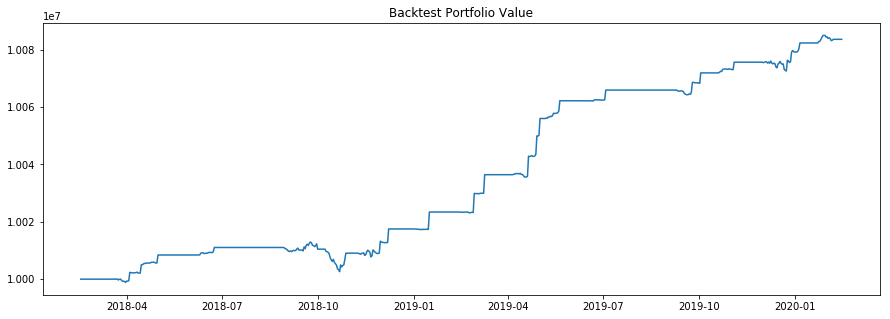

In [430]:
plt.figure(figsize=(15,5))
plt.plot(portfolio_df['portfolio_value'])
plt.title('Backtest Portfolio Value')
plt.show()